# Descriptive statistics on NPIs for COVID-19

This document shows descriptive statistics and illustrations of the non-pharmaceutical interventions (NPIs) implemented in response to the spread of COVID-19 in Q1 2020. The data on NPIs used in collected by KeyStone Strategy while the data on cases and deaths is collected by NY Times.

Questions tackled in this document include:

1. Which NPIs did US counties implement?
2. When were these NPIs implemented?
3. Is there a common order in terms of timing in which measures are taken?
4. At which point of the spread of COVID-19 did counties take on NPIs?

## Import packages and data

In [826]:
# Import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas.tseries.offsets import *
import datetime as dt


import seaborn as sns
%matplotlib inline

In [827]:
# Import data prepared by https://github.com/khakieconomics/covid_data
# This is panel data created using the information on deaths and cases from NY Times 
# and Non-Pharmaceutical Interventions from Keystone Strategy

df = pd.read_csv('../../covid_data/interventions_and_deaths.csv')
df.head()

,date,county,state_name,fips,cases,deaths,county_code,state,locality,locality_original,...,PC_4,PC_5,PC_6,SD,SD_2,SD_3,SDO,SDO_2,SDO_3,SDO_4
0,2020-03-01,Alameda,California,6001.0,1,0,1,CA,alameda county,alameda_county,...,0,0,0,0,0,0,0,0,0,0
1,2020-03-02,Alameda,California,6001.0,1,0,1,CA,alameda county,alameda_county,...,0,0,0,0,0,0,0,0,0,0
2,2020-03-03,Alameda,California,6001.0,2,0,1,CA,alameda county,alameda_county,...,0,0,0,0,0,0,0,0,0,0
3,2020-03-04,Alameda,California,6001.0,2,0,1,CA,alameda county,alameda_county,...,0,0,0,0,0,0,0,0,0,0
4,2020-03-05,Alameda,California,6001.0,2,0,1,CA,alameda county,alameda_county,...,0,0,0,0,0,0,0,0,0,0


## First checks on data

In [828]:
# Size of dataset
df.shape

(1074, 47)

In [829]:
# List of variables
df.columns

Index(['date', 'county', 'state_name', 'fips', 'cases', 'deaths',
       'county_code', 'state', 'locality', 'locality_original', 'CPV', 'CPV_2',
       'CPV_3', 'CPV_4', 'CPV_5', 'CPV_50', 'CPV_6', 'GS_10', 'GS_10_2',
       'GS_10_3', 'GS_100', 'GS_1000', 'GS_25', 'GS_25_2', 'GS_250',
       'GS_250_2', 'GS_50', 'GS_50_2', 'GS_500', 'LD', 'LD_2', 'NESC',
       'NESC_2', 'NESC_3', 'PC', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'PC_6', 'SD',
       'SD_2', 'SD_3', 'SDO', 'SDO_2', 'SDO_3', 'SDO_4'],
      dtype='object')

In [830]:
# Rename variables for better distinction
df = df.rename(columns={"SD": "SDA", "SD_2": "SDA_2", "SD_3": "SDA_3"})

In [831]:
# Make date variable a date
df["date"] = pd.to_datetime(df["date"])

In [832]:
# Do we see every date for every county? No
df[(df['date'] > '2020-03-01')]["date"].value_counts()

2020-03-16    29
2020-03-24    29
2020-03-21    29
2020-04-01    29
2020-03-15    29
2020-03-26    29
2020-03-20    29
2020-03-31    29
2020-03-14    29
2020-03-25    29
2020-03-19    29
2020-04-02    29
2020-03-30    29
2020-03-27    29
2020-03-17    29
2020-03-28    29
2020-03-18    29
2020-03-29    29
2020-03-22    29
2020-03-23    29
2020-03-11    28
2020-03-13    28
2020-03-12    28
2020-03-10    26
2020-03-09    24
2020-03-07    23
2020-03-08    23
2020-03-06    21
2020-03-05    19
2020-03-04    16
2020-03-03    14
2020-03-02    13
Name: date, dtype: int64

In [833]:
# How many times do we see each date?
df[(df['date'] > '2020-02-01') & (df['date'] < '2020-03-01')]["date"].value_counts()

2020-02-29    8
2020-02-28    8
2020-02-16    7
2020-02-23    7
2020-02-18    7
2020-02-25    7
2020-02-15    7
2020-02-22    7
2020-02-12    7
2020-02-19    7
2020-02-26    7
2020-02-11    7
2020-02-13    7
2020-02-20    7
2020-02-27    7
2020-02-10    7
2020-02-17    7
2020-02-24    7
2020-02-14    7
2020-02-21    7
2020-02-06    6
2020-02-09    6
2020-02-02    6
2020-02-03    6
2020-02-05    6
2020-02-07    6
2020-02-08    6
2020-02-04    6
Name: date, dtype: int64

In [834]:
# Note: This is an unbalanced panel.

### Focus on March and early April since NPIs were implemented then

In [835]:
# Create separate dataset for March since all NPIs happen in March
df_march = df[(df['date'] >= '2020-03-01')]

In [836]:
len(df_march["county"].unique())

29

In [837]:
dates = pd.DataFrame([[dt.datetime(2020,3,1),dt.datetime(2020,4,2)]], columns=['start', 'end'])
dates

,start,end
0,2020-03-01,2020-04-02


In [838]:
op_series = list()
for row in dates.itertuples():
    time_range = pd.date_range(row.start, row.end, freq=BDay())
    s = len(time_range)
    op_series += (zip(time_range, [row.start]*s, [row.end]*s))

df_dates = pd.DataFrame(op_series, columns=['date', 'start', 'end'])

In [839]:
df_dates = df_dates.drop(["start", "end"], axis=1)
df_dates

,date
0,2020-03-02
1,2020-03-03
2,2020-03-04
3,2020-03-05
4,2020-03-06
5,2020-03-09
6,2020-03-10
7,2020-03-11
8,2020-03-12
9,2020-03-13


In [840]:
# Which counties do we have?
counties = list(pd.unique(df_march["county"]))
counties

['Alameda',
 'Contra Costa',
 'Los Angeles',
 'San Diego',
 'San Francisco',
 'San Mateo',
 'Santa Clara',
 'Denver',
 'District of Columbia',
 'Miami-Dade',
 'Fulton',
 'Cook',
 'DuPage',
 'Lake',
 'Johnson',
 'Middlesex',
 'Norfolk',
 'Suffolk',
 'Wayne',
 'Bergen',
 'Hudson',
 'Clark',
 'Nassau',
 'New York City',
 'Rockland',
 'Westchester',
 'Dallas',
 'King',
 'Snohomish']

## Reduce information to unique intervention types

In [841]:
# Which unique kinds of interventions do we have?
npis_kind = ["CPV", "GS", "LD", "NESC", "PC", "SDA", "SDO"]

In [842]:
# Function to create dummy variable indicating whether any intervention of certain kind is in place

# INPUTS: df - dataframe, npis_kind - list of unique kinds of interventions
# OUTPUT: df with additional/overwritten dummy
def reduce_to_one_per_kind(df, npis_kind):
    for npi in npis_kind:
        npi_list = df.filter(regex=npi) # capture of all variables that capture information on this npi
        npi_list = list(npi_list.columns) # make it a list
        df[npi] = df[npi_list].max(axis=1) # overwrite/create dummy that is one if any npi of this kind is in place
    return df

In [843]:
# Apply function
reduce_to_one_per_kind(df, npis_kind)
reduce_to_one_per_kind(df_march, npis_kind)

/Users/henrikesteimer/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,date,county,state_name,fips,cases,deaths,county_code,state,locality,locality_original,...,PC_5,PC_6,SDA,SDA_2,SDA_3,SDO,SDO_2,SDO_3,SDO_4,GS
0,2020-03-01,Alameda,California,6001.0,1,0,1,CA,alameda county,alameda_county,...,0,0,0,0,0,0,0,0,0,0
1,2020-03-02,Alameda,California,6001.0,1,0,1,CA,alameda county,alameda_county,...,0,0,0,0,0,0,0,0,0,0
2,2020-03-03,Alameda,California,6001.0,2,0,1,CA,alameda county,alameda_county,...,0,0,0,0,0,0,0,0,0,0
3,2020-03-04,Alameda,California,6001.0,2,0,1,CA,alameda county,alameda_county,...,0,0,0,0,0,0,0,0,0,0
4,2020-03-05,Alameda,California,6001.0,2,0,1,CA,alameda county,alameda_county,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1069,2020-03-29,Snohomish,Washington,53061.0,1067,23,61,WA,snohomish county,snohomish_county,...,1,0,1,0,0,1,1,1,0,1
1070,2020-03-30,Snohomish,Washington,53061.0,1126,30,61,WA,snohomish county,snohomish_county,...,1,0,1,0,0,1,1,1,0,1
1071,2020-03-31,Snohomish,Washington,53061.0,1228,32,61,WA,snohomish county,snohomish_county,...,1,0,1,0,0,1,1,1,0,1
1072,2020-04-01,Snohomish,Washington,53061.0,1304,39,61,WA,snohomish county,snohomish_county,...,1,0,1,0,0,1,1,1,0,1


In [844]:
# Check list of variables
df.columns

Index(['date', 'county', 'state_name', 'fips', 'cases', 'deaths',
       'county_code', 'state', 'locality', 'locality_original', 'CPV', 'CPV_2',
       'CPV_3', 'CPV_4', 'CPV_5', 'CPV_50', 'CPV_6', 'GS_10', 'GS_10_2',
       'GS_10_3', 'GS_100', 'GS_1000', 'GS_25', 'GS_25_2', 'GS_250',
       'GS_250_2', 'GS_50', 'GS_50_2', 'GS_500', 'LD', 'LD_2', 'NESC',
       'NESC_2', 'NESC_3', 'PC', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'PC_6', 'SDA',
       'SDA_2', 'SDA_3', 'SDO', 'SDO_2', 'SDO_3', 'SDO_4', 'GS'],
      dtype='object')

In [845]:
# Drop additional variables on these NPIs that we don't want to focus on for now
col_extended_aux = df.filter(regex='(_1|_2|_3|_4|_5|_6)') # Find variables with extensions
col_extended = list(col_extended_aux.columns) # Make list
df = df.drop(col_extended, axis=1) # Drop variables with extensions
df_march = df_march.drop(col_extended, axis=1)
df.columns # Check remaining variables

Index(['date', 'county', 'state_name', 'fips', 'cases', 'deaths',
       'county_code', 'state', 'locality', 'locality_original', 'CPV', 'LD',
       'NESC', 'PC', 'SDA', 'SDO', 'GS'],
      dtype='object')

## Number of NPIs in place by date

In [846]:
# Create row sums and then check how many measures were in place at which date
# Create variable on number of NPIs in place at certain date
df["sum_npis"] = df[['CPV', 'LD', 'NESC', 'PC', 'SDA', 'SDO', 'GS']].sum(axis=1)
df_march["sum_npis"] = df_march[['CPV', 'LD', 'NESC', 'PC', 'SDA', 'SDO', 'GS']].sum(axis=1)

In [847]:
# Function to show how NPIs are in place, values become columns

# INPUTS: df - dataframe, group_var - variable to group by, sum_var - variable to summarize
# OUTPUT: df summarizing number of counties with certain number of sum_var

def count_values_unstack(df, group_var, sum_var):
    return df[df[sum_var] > 0].groupby(group_var)[sum_var].value_counts().unstack().fillna(0)

In [848]:
# How many counties have how many NPIs in place by day?

npis_per_day = count_values_unstack(df_march, "date", "sum_npis")
npis_per_day

sum_npis,1,2,3,4,5,6
date,,,,,,
2020-03-02,2.0,0.0,0.0,0.0,0.0,0.0
2020-03-03,3.0,0.0,0.0,0.0,0.0,0.0
2020-03-04,3.0,0.0,0.0,0.0,0.0,0.0
2020-03-05,3.0,1.0,0.0,0.0,0.0,0.0
2020-03-06,3.0,1.0,0.0,0.0,0.0,0.0
2020-03-07,3.0,1.0,0.0,0.0,0.0,0.0
2020-03-08,4.0,1.0,0.0,0.0,0.0,0.0
2020-03-09,10.0,1.0,0.0,0.0,0.0,0.0
2020-03-10,10.0,1.0,1.0,0.0,0.0,0.0


In [849]:
# On how many days do counties have how many NPIs in place?

count_values_unstack(df_march, "county", "sum_npis")

sum_npis,1,2,3,4,5,6
county,,,,,,
Alameda,3.0,1.0,3.0,1.0,0.0,17.0
Bergen,1.0,2.0,0.0,0.0,0.0,21.0
Clark,1.0,0.0,5.0,13.0,0.0,0.0
Contra Costa,4.0,0.0,3.0,1.0,0.0,17.0
Cook,0.0,5.0,0.0,13.0,0.0,0.0
Dallas,1.0,6.0,0.0,0.0,3.0,12.0
Denver,2.0,7.0,14.0,0.0,0.0,0.0
District of Columbia,2.0,6.0,17.0,0.0,0.0,0.0
DuPage,0.0,5.0,0.0,0.0,13.0,0.0


## Is there a common order in terms of timing in which measures are taken?

In [850]:
def nbr_npis_by_var(df, group_var):

    # INPUT: df - dataframe, group_var - variable to group by
    # OUTPUT: summary table with number of counties having each NPI in place by group_var
    
    sum_tab = df.groupby(group_var).agg(
    # Sum of closure of public venues
    CPV=('CPV', sum),
    # Sum of lock down
    LD=('LD', sum),
    # Sum of non-essential services closure
    NESC=('NESC', sum),
    # Sum of closure of schools and universities
    PC=('PC', sum),  
    # Sum of social distancing
    SDA=('SDA', sum),
    # Sum of social distancing of vulnerable groups
    SDO=('SDO', sum),
    # Sum of any gathering size limitations
    GS=('GS', sum)
    )
    return sum_tab

In [851]:
# Approach: show many counties have certain NPI in place at each date

nbr_npis_by_date = nbr_npis_by_var(df_march, "date")

nbr_npis_by_date = nbr_npis_by_date.reset_index()
nbr_npis_by_date = nbr_npis_by_date[nbr_npis_by_date["date"] > '2020-03-01']
nbr_npis_by_date = nbr_npis_by_date[nbr_npis_by_date["date"] < '2020-03-25']
nbr_npis_by_date

,date,CPV,LD,NESC,PC,SDA,SDO,GS
1,2020-03-02,0,0,0,2,0,0,0
2,2020-03-03,0,0,0,2,0,1,0
3,2020-03-04,0,0,0,2,0,1,0
4,2020-03-05,0,0,0,2,0,3,0
5,2020-03-06,0,0,0,2,0,3,0
6,2020-03-07,0,0,0,2,0,3,0
7,2020-03-08,0,0,0,2,0,4,0
8,2020-03-09,0,0,0,3,0,9,0
9,2020-03-10,0,0,0,3,1,11,0
10,2020-03-11,1,0,0,5,2,12,5


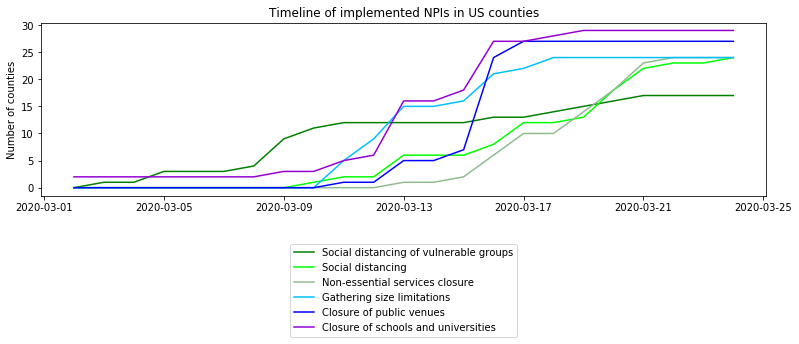

In [852]:
fig = plt.figure(figsize=(13,7))
fig.subplots_adjust()
ax1 = fig.add_subplot(211)
ax1.set_ylabel('Number of counties')
ax1.set_title('Timeline of implemented NPIs in US counties')

plt.plot(nbr_npis_by_date["date"], nbr_npis_by_date["SDO"], 'green', label="Social distancing of vulnerable groups")
plt.plot(nbr_npis_by_date["date"], nbr_npis_by_date["SDA"], 'lime', label="Social distancing")
plt.plot(nbr_npis_by_date["date"], nbr_npis_by_date["NESC"], 'darkseagreen', label="Non-essential services closure")
plt.plot(nbr_npis_by_date["date"], nbr_npis_by_date["GS"], 'deepskyblue', label="Gathering size limitations")
plt.plot(nbr_npis_by_date["date"], nbr_npis_by_date["CPV"], 'blue', label="Closure of public venues")
plt.plot(nbr_npis_by_date["date"], nbr_npis_by_date["PC"], 'darkviolet', label="Closure of schools and universities")

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(0.5, -0.25), loc='upper center') # borderaxespad=0.

fig.savefig('nbr_npis_by_date.png', dpi=100)

plt.show()

## Cluster counties by policies

### Study timing by number of cases

In [853]:
nbr_npis_by_cases = nbr_npis_by_var(df_march, "cases")
nbr_npis_by_cases = nbr_npis_by_cases.reset_index()

nbr_npis_by_cases

,cases,CPV,LD,NESC,PC,SDA,SDO,GS
0,1,0,0,0,0,0,5,0
1,2,0,0,0,0,0,3,0
2,3,0,0,0,1,0,3,0
3,4,0,0,0,2,0,0,0
4,5,1,0,0,2,0,2,0
...,...,...,...,...,...,...,...,...
418,33768,1,0,1,1,1,1,1
419,38087,1,0,1,1,1,1,1
420,43139,1,0,1,1,1,1,1
421,47440,1,0,1,1,1,1,1


### Study timing by number of deaths

In [854]:
nbr_npis_by_deaths = nbr_npis_by_var(df_march, "deaths")
nbr_npis_by_deaths = nbr_npis_by_deaths.reset_index()

nbr_npis_by_deaths

,deaths,CPV,LD,NESC,PC,SDA,SDO,GS
0,0,130,0,63,165,70,128,131
1,1,51,0,34,61,36,46,55
2,2,32,0,21,41,25,18,37
3,3,27,0,22,36,22,17,27
4,4,21,0,16,24,17,11,22
...,...,...,...,...,...,...,...,...
82,776,1,0,1,1,1,1,1
83,914,1,0,1,1,1,1,1
84,1096,1,0,1,1,1,1,1
85,1374,1,0,1,1,1,1,1


## Plot cases and NPIs by county

In [855]:
df_clara = df_march[df_march["fips"] == 6085] # Santa Clara
df_sf = df_march[df_march["fips"] == 6075] # San Francisco
df_nyc = df_march[df_march["county"] == "New York City"] # New York city

In [856]:
df_clara = df_county[df_county["date"] > '2020-03-01']
df_sf = df_county2[df_county2["date"] > '2020-03-01']
df_nyc = df_county3[df_county3["date"] > '2020-03-01']

In [857]:
# Function for plotting cases and implementation dates for different NPIs

# INPUTS
    # df - dataframe for county of interest
    # label - label of outcome variable
    # y - outcome variable (usually cases or deaths)
    # y_label - label for outcome variable
    # impl_dates - implementation dates of NPIs
    # fig_name - name under which figure shall be saved
    
# OUTPUT
    # plot

def plot_y_with_NPIs(df, label, y, y_label, impl_dates, fig_name):
    fig = plt.figure(figsize=(12,6))
    fig.subplots_adjust()
    ax1 = fig.add_subplot(211)
    
    ax1.set_ylabel(y_label)
    ax1.set_title('COVID-19 cases and implemented non-pharmaceutical interventions (NPIs)')

    plt.plot(df["date"], df[y], 'cornflowerblue', label=label)
    plt.axvline(pd.to_datetime(impl_dates[0]), 0, 30, label='Social distancing of vulnerable groups', color='green')
    plt.axvline(pd.to_datetime(impl_dates[1]), 0, 30, label='Gathering size limitations', color='deepskyblue')
    plt.axvline(pd.to_datetime(impl_dates[2]), 0, 30, label='Closure of schools and universities', color='darkviolet')
    plt.axvline(pd.to_datetime(impl_dates[3]), 0, 30, label='Closure of public venues', color='blue')
    plt.axvline(pd.to_datetime(impl_dates[4]), 0, 30, label='Social distancing', color='lime')
    plt.axvline(pd.to_datetime(impl_dates[5]), 0, 30, label='Non-essential services closure', color='darkseagreen')

    # Place a legend to the right of this smaller subplot.
    plt.legend(bbox_to_anchor=(0.5, -0.25), loc='upper center') # borderaxespad=0.
    fig.savefig(fig_name, dpi=100)

    plt.show()


### Santa Clara county

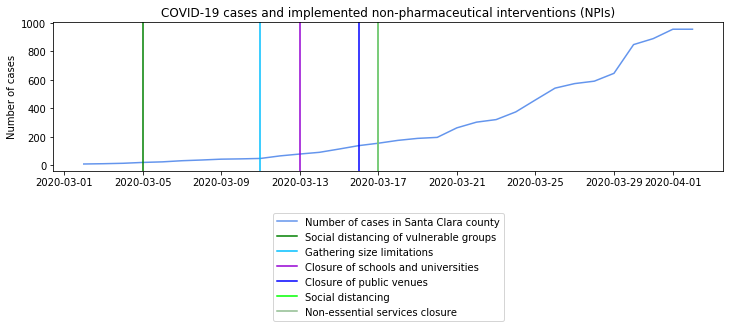

In [858]:
impl_dates = ['2020-03-05', '2020-03-11', '2020-03-13', '2020-03-16', '2020-03-17', '2020-03-17']
label = "Number of cases in Santa Clara county"
y_label = 'Number of cases'
y = "cases"
fig_name = "santa_clara.png"

plot_y_with_NPIs(df_clara, label, y, y_label, impl_dates, fig_name)

### San Francisco

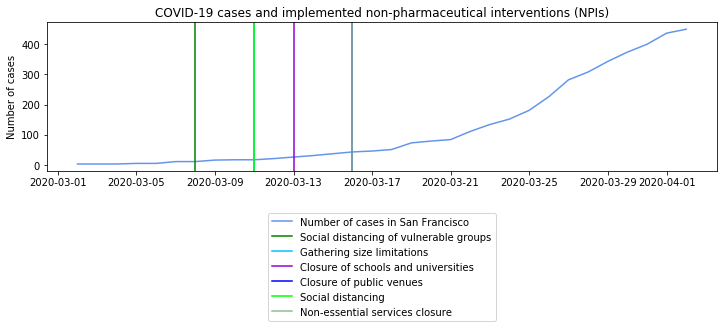

In [859]:

impl_dates = ['2020-03-08', '2020-03-11', '2020-03-13', '2020-03-16', '2020-03-11', '2020-03-16']
label = "Number of cases in San Francisco"
y_label = 'Number of cases'
y = "cases"
fig_name = "San_Francisco.png"

plot_y_with_NPIs(df_sf, label, y, y_label, impl_dates, fig_name)

### New York City

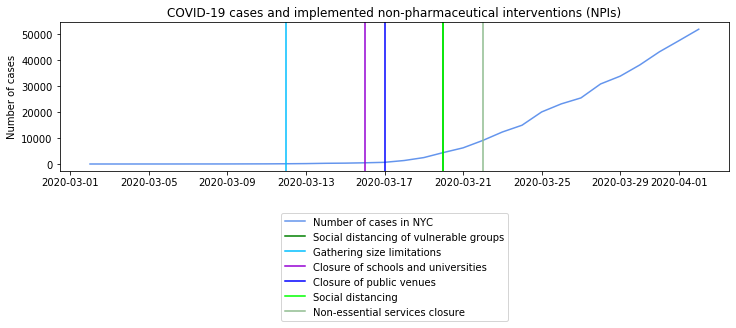

In [860]:
impl_dates = ['2020-03-20', '2020-03-12', '2020-03-16', '2020-03-17', '2020-03-20', '2020-03-22']
label = "Number of cases in NYC"
y_label = 'Number of cases'
y = "cases"
fig_name = "NYC.png"

plot_y_with_NPIs(df_nyc, label, y, y_label, impl_dates, fig_name)